In [24]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

import sys 
sys.path.append('..')

In [2]:
%%bash
fusermount -uz /mnt/work/dhuseljic
sshfs cluster.ies:/mnt/work/dhuseljic/ /mnt/work/dhuseljic

In [54]:

def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_model(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'

    exp_checkpoint = path / 'model_final.pth'
    state_dict = torch.load(exp_checkpoint)
    return state_dict

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'

    cfg_path = path / '.hydra' / 'config.yaml'
    args =  OmegaConf.load(cfg_path)
    return args

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    exp_json = path / 'results.json'
    if exp_json.is_file():
        results = load_json(exp_json)
    else:
        raise ValueError(f'Results missing for {exp_json}')
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    for exp_path in result_path.glob(glob_pattern):
        print('> Found', exp_path.name)
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'/mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{18}/'
exp_results = get_experiments(Path(path), 'seed1')
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18
> Found seed1


KeyError: 'results'

In [55]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
# root_path = Path('/home/denis/results/udal/')
dataset = 'CIFAR10'
model = 'resnet18'
experiments = {}
n_init = 128
acq_size = 128
num_cycles = 38
# Deterministic
experiments.update({
    'random eval':  root_path / f'overconfidence/{dataset}/resnet18/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'lc eval':      root_path / f'overconfidence/{dataset}/resnet18/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin eval':  root_path / f'overconfidence/{dataset}/resnet18/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval': root_path / f'overconfidence/{dataset}/resnet18/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/4 [00:00<?, ?it/s]

Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed6
> Found seed1
> Found seed10
> Found seed5
> Found seed2
> Found seed8
> Found seed7
> Found seed9
> Found seed3
> Found seed4


 25%|██▌       | 1/4 [00:01<00:03,  1.14s/it]

Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed5
> Found seed2
> Found seed8
> Found seed6
> Found seed1
> Found seed9
> Found seed3
> Found seed10
> Found seed4
> Found seed7


 50%|█████     | 2/4 [00:02<00:02,  1.17s/it]

Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed4
> Found seed9
> Found seed3
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Found seed5
> Found seed10


 75%|███████▌  | 3/4 [00:03<00:01,  1.18s/it]

Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed5
> Found seed10
> Found seed2
> Found seed8
> Found seed6
> Found seed1
> Found seed9
> Found seed3
> Found seed4
> Found seed7


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


In [59]:
show_std = False
learning_curves = {}

for strat_name, results in tqdm(all_results.items()):

    test_oces = []
    n_labeled_samples = []

    for seed_results in results:
        n_labeled_samples.append([seed_results[cycle]['n_labeled_samples'] for cycle in seed_results])
        test_oces.append([seed_results[cycle]['test_stats']['oce'] for cycle in seed_results])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_oces_mean, test_oces_std = np.mean(test_oces, 0), np.std(test_oces, 0)

    learning_curves[strat_name] = {
        'oce': test_oces_mean, 'oce_std': test_oces_std,
    }

100%|██████████| 4/4 [00:00<00:00, 2816.86it/s]


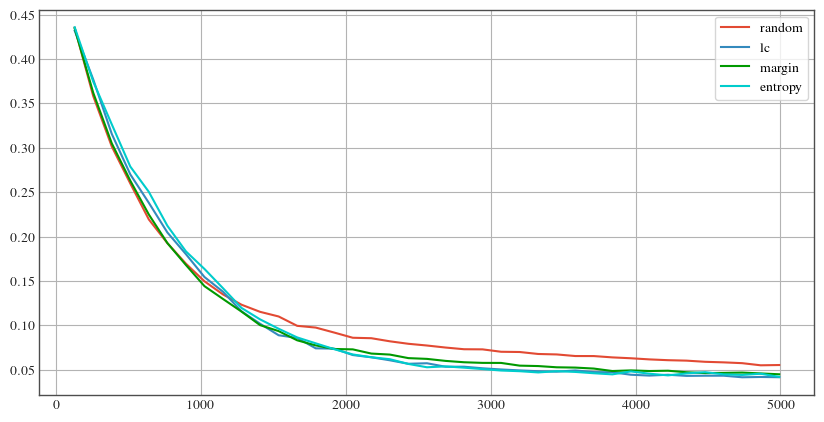

In [94]:
oce = learning_curves['random eval']['oce']
oce_std = learning_curves['random eval']['oce_std']
plt.plot(n_labeled_samples, oce, label='random')

oce = learning_curves['lc eval']['oce']
oce_std = learning_curves['random eval']['oce_std']
plt.plot(n_labeled_samples, oce, label='lc')

oce = learning_curves['margin eval']['oce']
oce_std = learning_curves['random eval']['oce_std']
plt.plot(n_labeled_samples, oce, label='margin')

oce = learning_curves['entropy eval']['oce']
oce_std = learning_curves['random eval']['oce_std']
plt.plot(n_labeled_samples, oce, label='entropy')

plt.legend()

plt.show()

In [93]:
import pandas as pd

{key: val['oce'][-1] for key, val in learning_curves.items()}

{'random eval': 0.055341587960720064,
 'lc eval': 0.04161111414432526,
 'margin eval': 0.04491196721792221,
 'entropy eval': 0.04201927706599236}

In [75]:
from active_learning import build_model, build_datasets

exp_path = experiments['random eval'] / 'seed1'

state_dict = load_model(exp_path)
args = load_args(exp_path)
results = load_results(exp_path)

data = build_datasets(args)
model = build_model(args, num_classes=10)
model = model.model
model.load_state_dict(state_dict)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [76]:
torch.set_grad_enabled(False)

model.eval()
model.cuda()
test_loader = torch.utils.data.DataLoader(data.test_dataset, batch_size=256)

logits_list = []
targets_list = []
for batch in tqdm(test_loader):
    inputs, targets = batch
    logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:02<00:00, 19.91it/s]


In [77]:
print('Test Accuracy:', (logits.argmax(-1) == targets).float().mean().item())
results['cycle38']['test_stats']

Test Accuracy: 0.8489999771118164


{'accuracy': 0.8490999937057495,
 'nll': 0.5365116596221924,
 'brier': 0.23503151535987854,
 'tce': 0.06616222113370895,
 'ace': 0.054619304835796356,
 'oce': 0.05762855336070061}

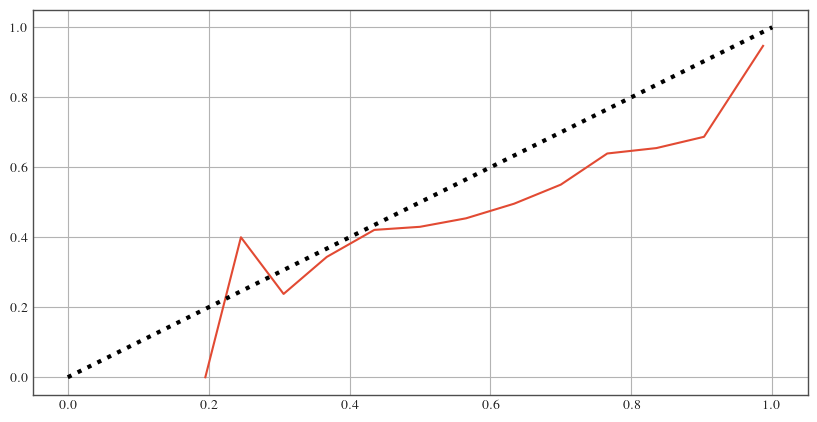

In [86]:
from dal_toolbox.metrics import TopLabelCalibrationPlot

probas = logits.softmax(-1)
tcp = TopLabelCalibrationPlot()(probas, targets)
plt.plot(tcp['confs'], tcp['accs'])
plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle=':')